# Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import pearsonr, randint

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")

plot_font_size = 18
random_state = 42

In [11]:
dataset_file = "/content/RFLFSODataFull.csv"
data = pd.read_csv(dataset_file)

In [12]:
data.head()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.0,0.0,0.0,...,26.603030,24.680849,9,65884.51846,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.0,0.0,0.0,...,26.377164,24.313108,9,64963.41092,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.0,0.0,0.0,...,27.670822,23.150277,10,54794.28107,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.0,0.0,0.0,...,26.522100,23.174815,10,50205.64159,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.0,0.0,0.0,...,26.305736,24.864100,10,59038.32599,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052


In [13]:
data.columns

Index(['FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'AbsoluteHumidityMax',
       'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate',
       'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax',
       'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature',
       'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time',
       'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection',
       'WindSpeed', 'WindSpeedMax', 'WindSpeedMin'],
      dtype='object')

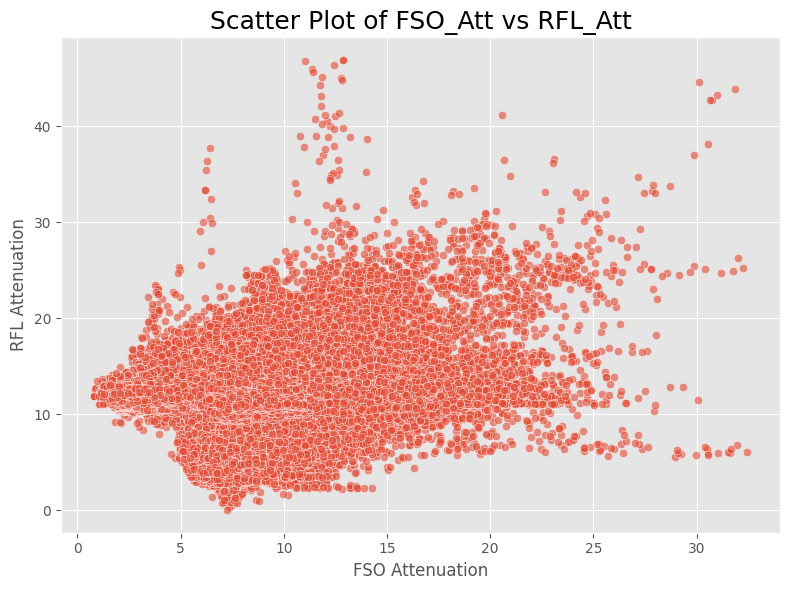

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='FSO_Att', y='RFL_Att', alpha=0.6)
plt.title('Scatter Plot of FSO_Att vs RFL_Att', fontsize=plot_font_size)
plt.xlabel('FSO Attenuation')
plt.ylabel('RFL Attenuation')
plt.tight_layout()
plt.show()

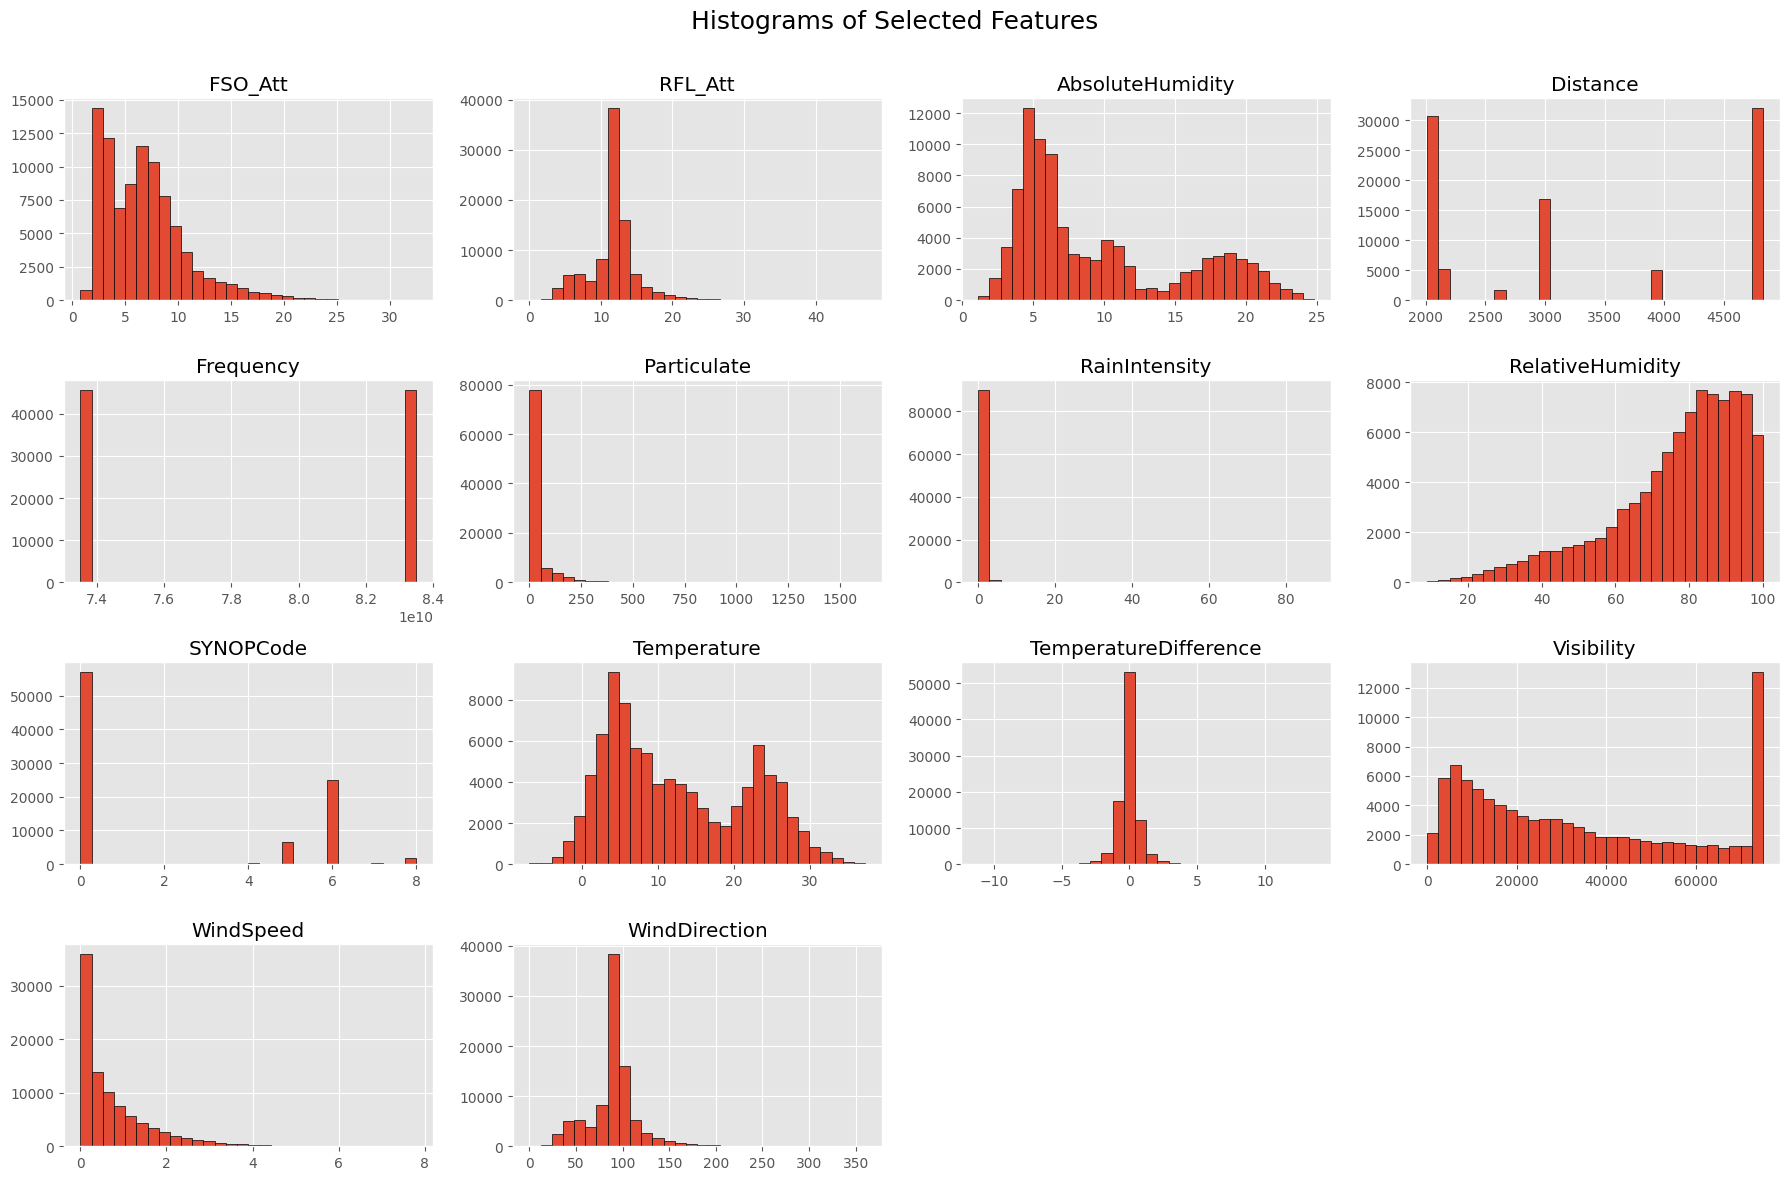

In [15]:
selected_columns = [
    'FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'Distance', 'Frequency',
    'Particulate', 'RainIntensity', 'RelativeHumidity', 'SYNOPCode',
    'Temperature', 'TemperatureDifference', 'Visibility',
    'WindSpeed', 'WindDirection'
]

data[selected_columns].hist(figsize=(18, 12), bins=30, edgecolor='black')
plt.suptitle('Histograms of Selected Features', fontsize=plot_font_size)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

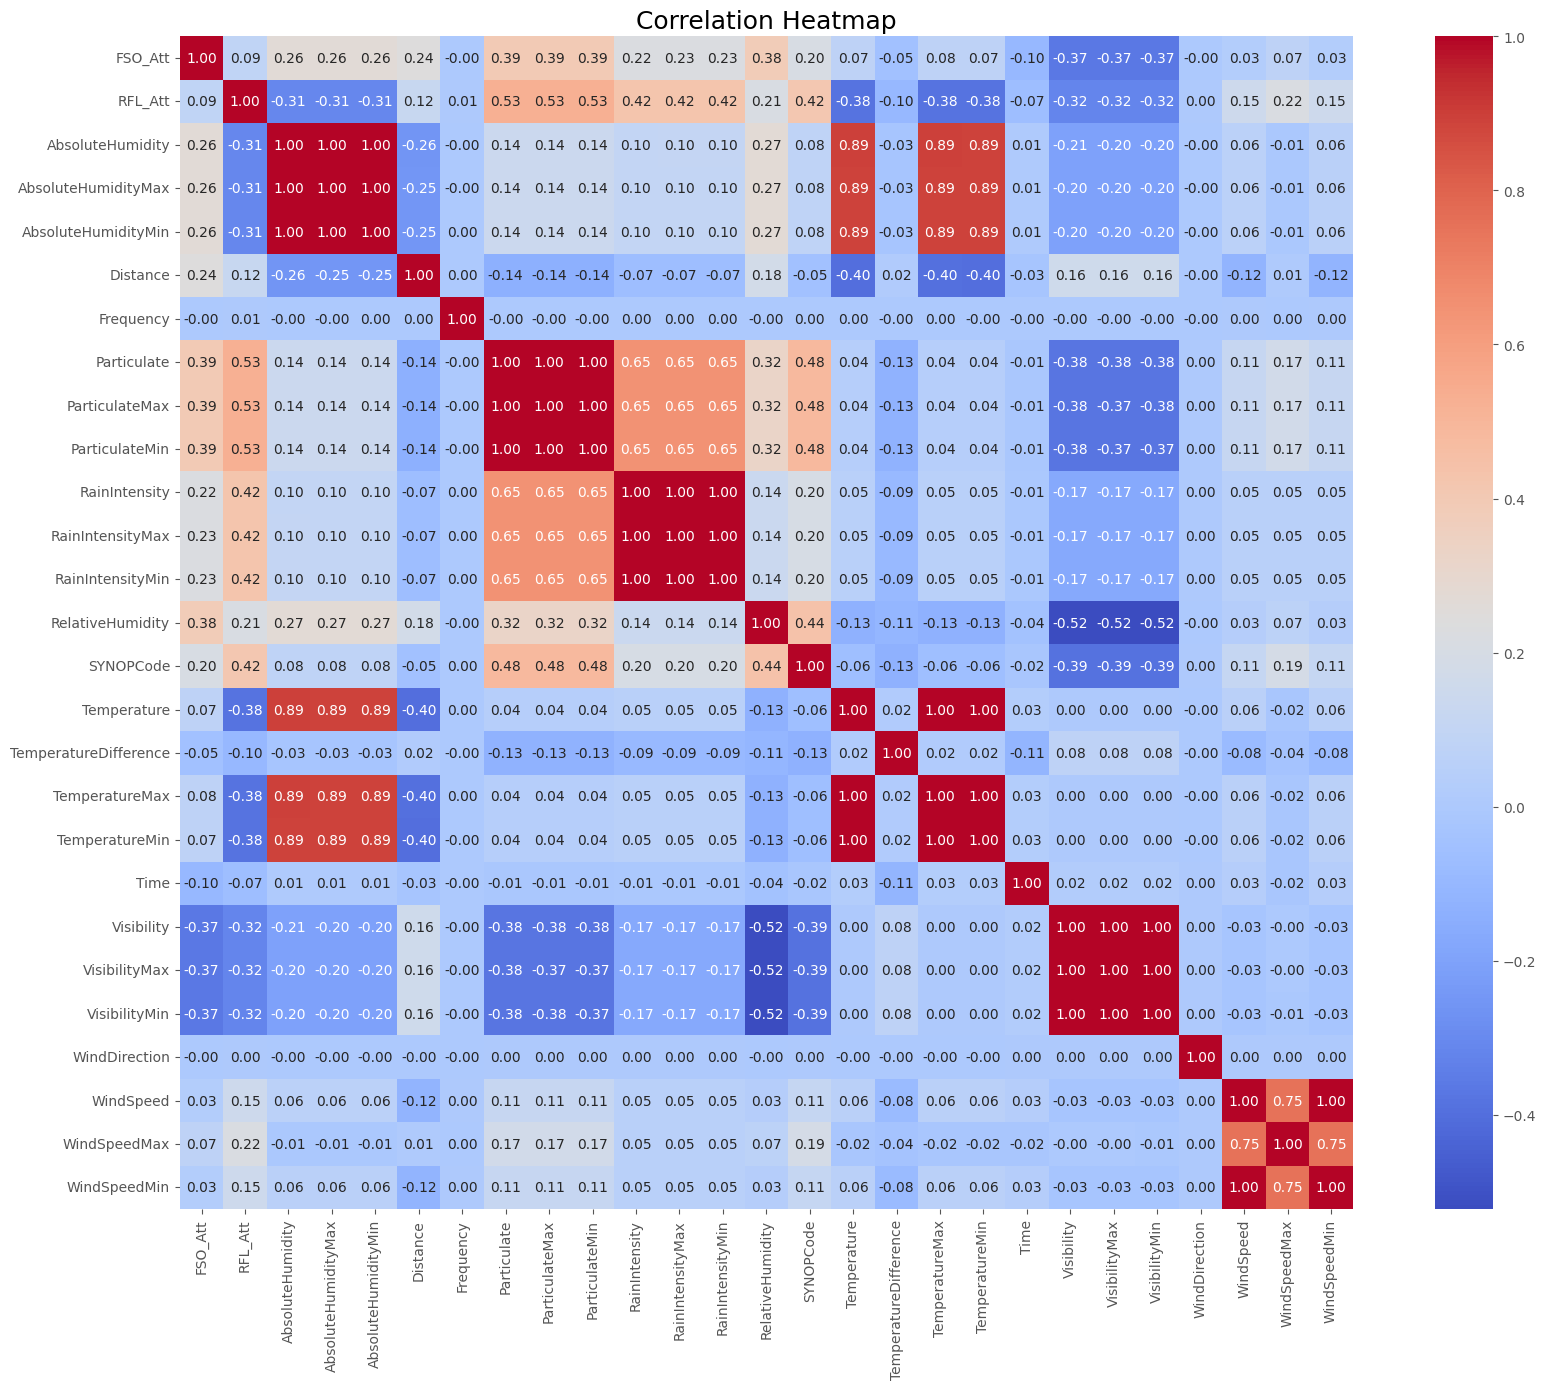

In [16]:
plt.figure(figsize=(18, 14))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap', fontsize=plot_font_size)
plt.tight_layout()
plt.show()

# Feature selection

In [17]:
def feature_removal_fso_updated(data, target='FSO_Att', aux_target='RFL_Att', random_state=42):
    S = data.drop(columns=[target, aux_target]).columns.tolist()
    R = pd.DataFrame(columns=['Feature Removed', 'RMSE', 'R²'])

    while S:
        # Use current feature set to train FSO_Att
        X = data[S + [aux_target]]  # Keep aux_target as an additional input
        y = data[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
        model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,
                                      min_samples_leaf=2, random_state=random_state, n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        R = pd.concat([R, pd.DataFrame([{'Feature Removed': None, 'RMSE': rmse, 'R²': r2}])], ignore_index=True)

        importances = model.feature_importances_
        feature_list = S + [aux_target]
        feature_importance_df = pd.DataFrame({'Feature': feature_list, 'Importance': importances})

        # Avoid removing aux_target
        feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != aux_target]

        least_important = feature_importance_df.loc[feature_importance_df['Importance'].idxmin()]
        R.iloc[-1, 0] = least_important['Feature']
        S.remove(least_important['Feature'])

    return R

def feature_removal_rfl_updated(data, target='RFL_Att', aux_target='FSO_Att', random_state=42):
    S = data.drop(columns=[target, aux_target]).columns.tolist()
    R = pd.DataFrame(columns=['Feature Removed', 'RMSE', 'R²'])

    while S:
        train_df, test_df_original = train_test_split(data, test_size=0.3, random_state=random_state)
        test_df_predicted = test_df_original.copy()

        # Step 1: Train model for aux_target (FSO_Att)
        X1 = train_df[S + [target]]
        y1 = train_df[aux_target]

        rf1 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,
                                    min_samples_leaf=2, random_state=random_state, n_jobs=-1)
        rf1.fit(X1, y1)

        # Predict aux_target (FSO_Att) for both train and test
        train_df_pred = train_df.copy()
        train_df_pred[aux_target] = rf1.predict(X1)

        X2 = train_df_pred[S + [aux_target]]
        y2 = train_df[target]

        rf2 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,
                                    min_samples_leaf=2, random_state=random_state, n_jobs=-1)
        rf2.fit(X2, y2)

        # Predict on test set
        X1_test = test_df_original[S + [target]]
        test_df_predicted[aux_target] = rf1.predict(X1_test)
        X2_test = test_df_predicted[S + [aux_target]]
        y_test = test_df_original[target]
        y_pred = rf2.predict(X2_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        R = pd.concat([R, pd.DataFrame([{'Feature Removed': None, 'RMSE': rmse, 'R²': r2}])], ignore_index=True)

        importances = rf2.feature_importances_
        feature_list = S + [aux_target]
        feature_importance_df = pd.DataFrame({'Feature': feature_list, 'Importance': importances})

        # Avoid removing aux_target
        feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != aux_target]

        least_important = feature_importance_df.loc[feature_importance_df['Importance'].idxmin()]
        R.iloc[-1, 0] = least_important['Feature']
        S.remove(least_important['Feature'])

    return R

In [18]:
# Sample 20%
df = data.sample(frac=0.2, random_state=random_state).reset_index(drop=True)

fso_results = feature_removal_fso_updated(df)
rfl_results = feature_removal_rfl_updated(df)

# Sorting the results based on R² in descending order
fso_results_sorted = fso_results.sort_values(by='R²', ascending=False)
rfl_results_sorted = rfl_results.sort_values(by='R²', ascending=False)

# Print the sorted results
print("FSO Results Sorted by R²:")
print(fso_results_sorted)

print("\nRFL Results Sorted by R²:")
print(rfl_results_sorted)

FSO Results Sorted by R²:
          Feature Removed      RMSE        R²
10           WindSpeedMin  1.306041  0.886239
9     AbsoluteHumidityMax  1.309158  0.885696
7            WindSpeedMax  1.309370  0.885659
6               WindSpeed  1.309453  0.885644
5           RainIntensity  1.310054  0.885539
0               Frequency  1.311644  0.885261
2               SYNOPCode  1.311772  0.885239
8     AbsoluteHumidityMin  1.312006  0.885198
1        RainIntensityMin  1.312123  0.885177
3        RainIntensityMax  1.313298  0.884972
4           WindDirection  1.314429  0.884773
11  TemperatureDifference  1.321228  0.883578
12                   Time  1.340360  0.880182
13       RelativeHumidity  1.383125  0.872415
14         TemperatureMax  1.392225  0.870730
15       AbsoluteHumidity  1.392889  0.870607
21            Particulate  1.433885  0.862878
19          VisibilityMax  1.434434  0.862773
18         ParticulateMax  1.434910  0.862682
20          VisibilityMin  1.438336  0.862025
16      

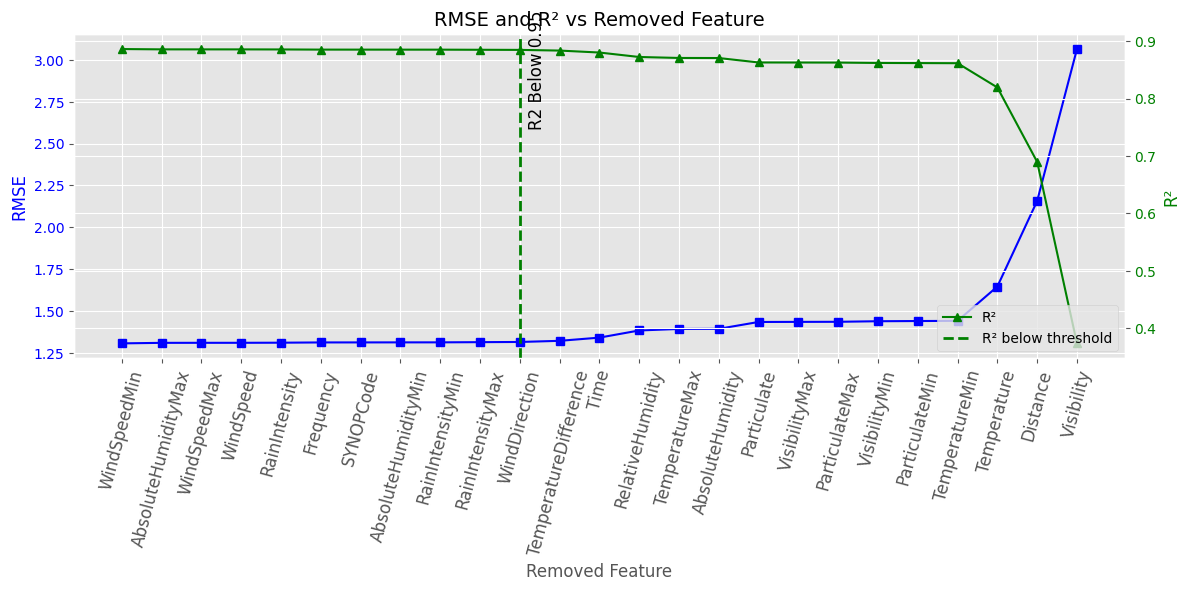

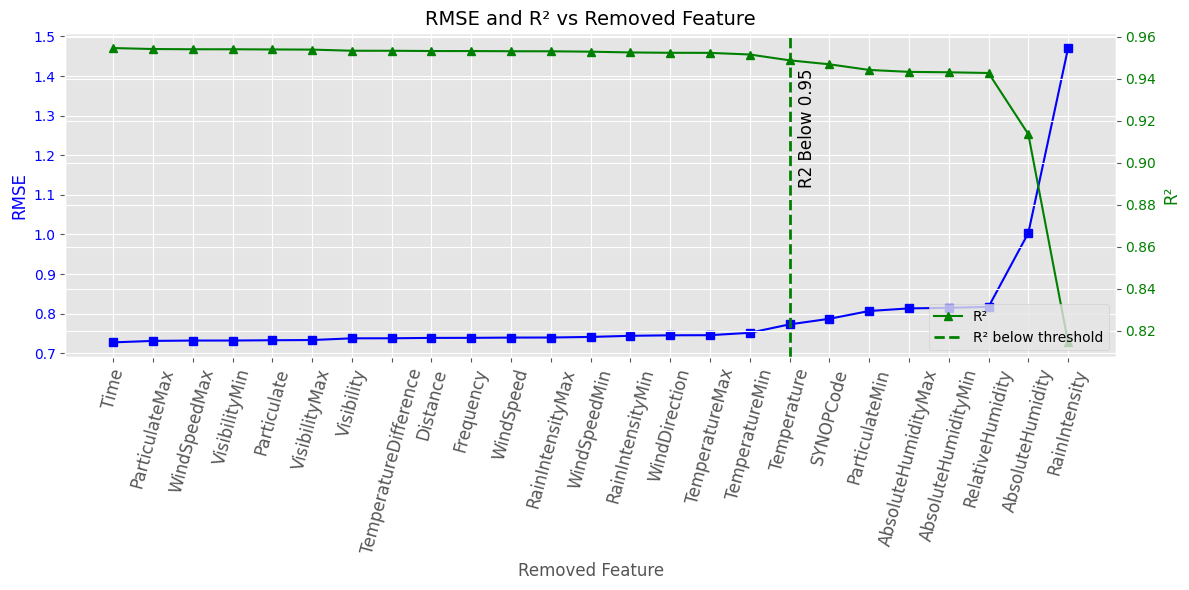

In [19]:
def plot_rmse_r2(results_df, r2_threshold=0.95):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    f_size = 12

    features = results_df['Feature Removed']
    rmse = results_df['RMSE']
    r2 = results_df['R²']

    # Primary y-axis: RMSE
    ax1.set_xlabel('Removed Feature', fontsize=f_size)
    ax1.set_ylabel('RMSE', color='blue', fontsize=f_size)
    ax1.plot(features, rmse, marker='s', color='blue', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(range(len(features)))
    ax1.set_xticklabels(features, rotation=75, fontsize=f_size)

    # Secondary y-axis: R²
    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='green', fontsize=f_size)
    ax2.plot(features, r2, marker='^', color='green', label='R²')
    ax2.tick_params(axis='y', labelcolor='green')

    # Find where R² drops below threshold
    below_threshold = r2[r2 < r2_threshold]
    if not below_threshold.empty:
        drop_index = below_threshold.index[0]
        ax2.axvline(x=drop_index, color='green', linestyle='--', linewidth=2, label='R² below threshold')
        ax2.text(drop_index + 0.2, max(r2)*0.96,
                 f"R2 Below {r2_threshold:.2f}",
                 rotation=90, color='black', fontsize=f_size, va='center')

    ax2.legend(loc='lower right')
    plt.title('RMSE and R² vs Removed Feature', fontsize=f_size + 2)
    fig.tight_layout()
    plt.grid(True)
    plt.show()


plot_rmse_r2(fso_results_sorted)
plot_rmse_r2(rfl_results_sorted)

# Method 2 and 3 (with hyperparameter tuning)

In [20]:
def get_features_above_r2_threshold(results_df, threshold=0.95):
    below_threshold = results_df[results_df['R²'] < threshold]
    if not below_threshold.empty:
        drop_index = below_threshold.index[0]
        return results_df.loc[:drop_index - 1, 'Feature Removed'].tolist()
    return results_df['Feature Removed'].tolist()

def tune_rf(X, y, random_state):
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': randint(5, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }

    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)
    search = RandomizedSearchCV(
        rf, param_distributions=param_dist,
        n_iter=10, scoring='neg_mean_squared_error',
        cv=3, random_state=random_state, n_jobs=-1
    )
    search.fit(X, y)

    print("Best Hyperparameters:", search.best_params_)

    return search.best_estimator_

def train_and_predict(df, target_cols, fso_features, rfl_features, random_state):
    train_df, test_df_original = train_test_split(df, test_size=0.3, random_state=random_state)
    test_df_predicted = test_df_original.copy()
    models = {}
    target1, target2 = target_cols

    if target1 == 'FSO_Att':
        selected_features_1 = fso_features + [target2]
        selected_features_2 = fso_features + [target1]
    else:
        selected_features_1 = rfl_features + [target2]
        selected_features_2 = rfl_features + [target1]

    # Model 1
    print(f"\nTraining Model 1 to predict: {target1}")
    X_train1 = train_df[selected_features_1]
    y_train1 = train_df[target1]

    rf_model1 = tune_rf(X_train1, y_train1, random_state)
    models[target1] = rf_model1

    X_test1 = test_df_original[selected_features_1]
    test_df_predicted[target1] = rf_model1.predict(X_test1)

    # Model 2
    print(f"\nTraining Model 2 to predict: {target2}, using predicted {target1}")
    X_train2 = train_df[selected_features_2].copy()
    X_train2[target1] = rf_model1.predict(X_train1)
    y_train2 = train_df[target2]

    rf_model2 = tune_rf(X_train2, y_train2, random_state)
    models[target2] = rf_model2

    X_test2 = test_df_predicted[selected_features_2].copy()
    test_df_predicted[target2] = rf_model2.predict(X_test2)

    return test_df_original, test_df_predicted, models

def evaluate_model(actual_df, predicted_df, target_col):
    if target_col not in actual_df.columns or target_col not in predicted_df.columns:
        print(f"Warning: Target column '{target_col}' not found in one or both DataFrames.")
        return

    y_actual = actual_df[target_col].values
    y_pred = predicted_df[target_col].values

    if len(y_actual) != len(y_pred):
        print(f"Error: Length mismatch in evaluate_model for {target_col}. Actual: {len(y_actual)}, Predicted: {len(y_pred)}")
        return

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2 = r2_score(y_actual, y_pred)

    print(f"\nEvaluation for {target_col} (on Test Set):")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}")

In [21]:
fso_features = get_features_above_r2_threshold(fso_results_sorted)
rfl_features = get_features_above_r2_threshold(rfl_results_sorted)

print("\n--- Method 2 (FSO then RFL) ---")
target_cols_m2 = ["FSO_Att", "RFL_Att"]
original_test_df_m2, predicted_test_df_m2, models_m2 = train_and_predict(
    data, target_cols=target_cols_m2, fso_features=fso_features, rfl_features=rfl_features, random_state=random_state
)

evaluate_model(original_test_df_m2, predicted_test_df_m2, target_col="RFL_Att")


print("\n--- Method 3 (RFL then FSO) ---")
target_cols_m3 = ["RFL_Att", "FSO_Att"]
original_test_df_m3, predicted_test_df_m3, models_m3 = train_and_predict(
    data, target_cols=target_cols_m3, fso_features=fso_features, rfl_features=rfl_features, random_state=random_state
)

evaluate_model(original_test_df_m3, predicted_test_df_m3, target_col="FSO_Att")


--- Method 2 (FSO then RFL) ---

Training Model 1 to predict: FSO_Att
Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 149}

Training Model 2 to predict: RFL_Att, using predicted FSO_Att
Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 149}

Evaluation for RFL_Att (on Test Set):
  - RMSE: 1.6391
  - R² Score: 0.7710

--- Method 3 (RFL then FSO) ---

Training Model 1 to predict: RFL_Att
Best Hyperparameters: {'max_depth': 17, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 98}

Training Model 2 to predict: FSO_Att, using predicted RFL_Att
Best Hyperparameters: {'max_depth': 17, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 98}

Evaluation for FSO_Att (on Test Set):
  - RMSE: 0.9484
  - R² Score: 0.9399


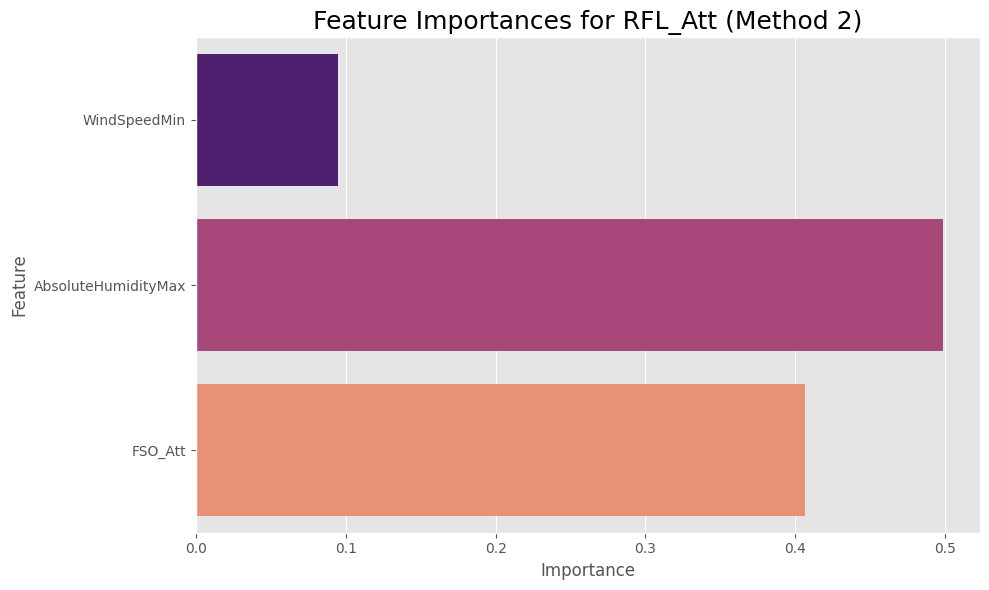

In [22]:
importances_rfl_m2 = models_m2['RFL_Att'].feature_importances_
features_rfl_m2 = models_m2['RFL_Att'].feature_names_in_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_rfl_m2, y=features_rfl_m2, palette="magma")
plt.title("Feature Importances for RFL_Att (Method 2)", fontsize=plot_font_size)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

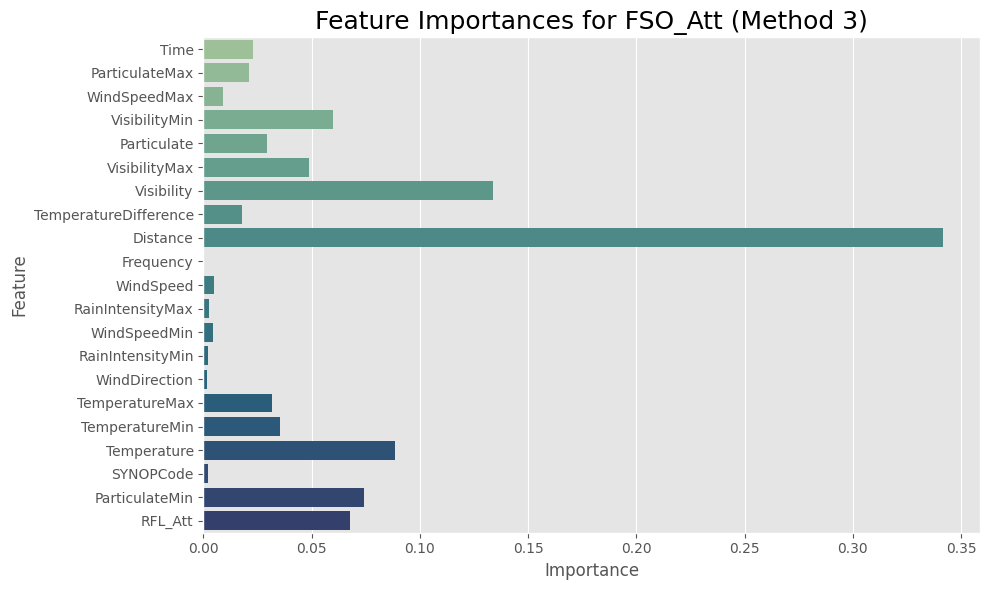

In [23]:
importances_fso_m3 = models_m3['FSO_Att'].feature_importances_
features_fso_m3 = models_m3['FSO_Att'].feature_names_in_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_fso_m3, y=features_fso_m3, palette="crest")
plt.title("Feature Importances for FSO_Att (Method 3)", fontsize=plot_font_size)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Mutual information

In [24]:
import pandas as pd
import numpy as np

def calculate_mutual_information(df, x_col, y_col, bins=40, verbose=True):
    try:
        # --- Input Validation and Preparation ---
        if x_col not in df.columns or y_col not in df.columns:
             print(f"Error: Column '{x_col}' or '{y_col}' not found in DataFrame.")
             return np.nan, None

        # Drop rows with NaN in either column to ensure consistent data
        subset_df = df[[x_col, y_col]].dropna().copy()

        if len(subset_df) < 2: # Need at least 2 data points for meaningful calculation
             print(f"Warning: Less than 2 non-NaN data points for pair ('{x_col}', '{y_col}'). Cannot calculate MI.")
             return np.nan, None

        # Check for constant columns after dropping NaNs
        if subset_df[x_col].nunique() <= 1 or subset_df[y_col].nunique() <= 1:
             if verbose:
                 print(f"Warning: Column '{x_col}' or '{y_col}' has <= 1 unique value after dropping NaNs. MI is 0.")
             # MI is 0 if one variable is constant
             # Create a dummy joint_prob_df for consistency if needed, though it represents no info
             # For simplicity, return 0 MI and None joint prob
             return 0.0, None

        # --- Step 1: Discretize ---
        # Use labels=False to get numerical bin indices. include_lowest=True ensures edge values are included.
        subset_df['x_binned'] = pd.cut(subset_df[x_col], bins=bins, labels=False, retbins=False, include_lowest=True, duplicates='drop')
        subset_df['y_binned'] = pd.cut(subset_df[y_col], bins=bins, labels=False, retbins=False, include_lowest=True, duplicates='drop')

        # Drop rows where binning might have failed (though less likely with checks above)
        binned_df = subset_df[['x_binned', 'y_binned']].dropna()
        if binned_df.empty:
             print(f"Warning: No valid data points after binning for pair ('{x_col}', '{y_col}'). MI set to 0.")
             return 0.0, None

        # --- Step 2: Joint Probability ---
        joint_counts = pd.crosstab(binned_df['x_binned'], binned_df['y_binned'])
        total_counts = joint_counts.values.sum()

        if total_counts == 0:
            if verbose:
                print(f"Warning: Zero total counts after binning for pair ('{x_col}', '{y_col}'). MI set to 0.")
            return 0.0, None

        joint_prob_df = joint_counts / total_counts
        joint_prob_flat = joint_prob_df.values.flatten() # For H(X,Y) calculation

        # --- Step 3: Marginal Probabilities ---
        p_x = joint_prob_df.sum(axis=1).values  # P(X)
        p_y = joint_prob_df.sum(axis=0).values  # P(Y)

        # --- Step 4: Entropies ---
        def entropy(p):
            """Calculates Shannon entropy for a probability distribution."""
            p_nonzero = p[p > 0]
            if len(p_nonzero) == 0:
                return 0.0 # Entropy is 0 if no non-zero probabilities
            return -np.sum(p_nonzero * np.log2(p_nonzero))

        H_X = entropy(p_x)
        H_Y = entropy(p_y)
        # Use the flattened joint probability array for joint entropy
        H_XY = entropy(joint_prob_flat)

        # --- Step 5: Mutual Information ---
        # MI = H(X) + H(Y) - H(X,Y)
        # Ensure MI is not negative due to potential floating point inaccuracies
        mi = max(0.0, H_X + H_Y - H_XY)

        if verbose:
            print(f"\n--- Mutual Information Results ({x_col} vs {y_col}) ---")
            print(f"H({x_col}): {H_X:.4f} bits")
            print(f"H({y_col}): {H_Y:.4f} bits")
            print(f"H({x_col}, {y_col}): {H_XY:.4f} bits")
            print(f"Mutual Information I({x_col} ; {y_col}): {mi:.4f} bits")

        return mi, joint_prob_df

    except Exception as e:
        print(f"Error calculating MI for ({x_col}, {y_col}): {e}")
        return np.nan, None

Plotting the Joint Probability Distribution (MI = 0.3667 bits)


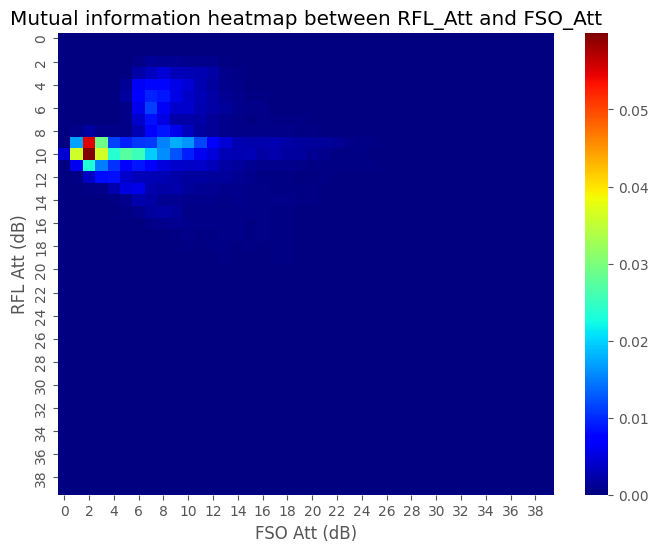

In [25]:
# Calculate MI and get the joint probability table for the SPECIFIC PAIR
mi_value, joint_distribution = calculate_mutual_information(data, x_col="RFL_Att", y_col="FSO_Att", bins=40, verbose=False)

# Check if the joint distribution was successfully calculated
if joint_distribution is not None and not joint_distribution.empty:
    print(f"Plotting the Joint Probability Distribution (MI = {mi_value:.4f} bits)")
    plt.figure(figsize=(8, 6))
    sns.heatmap(joint_distribution, cmap="jet")
    plt.title("Mutual information heatmap between RFL_Att and FSO_Att")
    plt.xlabel("FSO Att (dB)")
    plt.ylabel("RFL Att (dB)")
    plt.show()
else:
    print("Could not plot joint probability distribution (calculation might have failed).")

# Correlation vs Mutual information

In [26]:
# Map SYNOP codes to weather types
synop_labels = {
    0: 'clear',
    3: 'dust storm',
    4: 'fog',
    5: 'drizzle',
    6: 'rain',
    7: 'snow',
    8: 'showers'
}

# Combine test sets with original and predicted values
combined_df = original_test_df_m2[['SYNOPCode', 'RFL_Att', 'FSO_Att']].copy()
combined_df['RFL_Att_pred'] = predicted_test_df_m3['RFL_Att'].values
combined_df['FSO_Att_pred'] = predicted_test_df_m2['FSO_Att'].values

# Function to calculate normalized mutual information
def calculate_normalized_mutual_information(x, y, bins=10):
    c_xy = np.histogram2d(x, y, bins)[0]
    pxy = c_xy / np.sum(c_xy)

    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)

    H_x = -np.sum(px[px > 0] * np.log2(px[px > 0]))
    H_y = -np.sum(py[py > 0] * np.log2(py[py > 0]))
    H_xy = -np.sum(pxy[pxy > 0] * np.log2(pxy[pxy > 0]))

    mutual_info = H_x + H_y - H_xy

    return mutual_info / H_xy if H_xy > 0 else np.nan

# Compute correlation values per SYNOPCode
results = {'SYNOPCode': [], 'r_EO': [], 'I_EO_H_EO': []}

for code in combined_df['SYNOPCode'].unique():
    sub_df = combined_df[combined_df['SYNOPCode'] == code]

    try:
        r_measured, _ = pearsonr(sub_df['RFL_Att'], sub_df['FSO_Att'])
    except:
        r_measured = np.nan

    try:
        norm_mi = calculate_normalized_mutual_information(
            sub_df['RFL_Att_pred'], sub_df['FSO_Att_pred'], bins=10
        )
    except:
        norm_mi = np.nan

    results['SYNOPCode'].append(code)
    results['r_EO'].append(r_measured)
    results['I_EO_H_EO'].append(norm_mi)

corr_df = pd.DataFrame(results)
corr_df.sort_values('SYNOPCode', inplace=True)

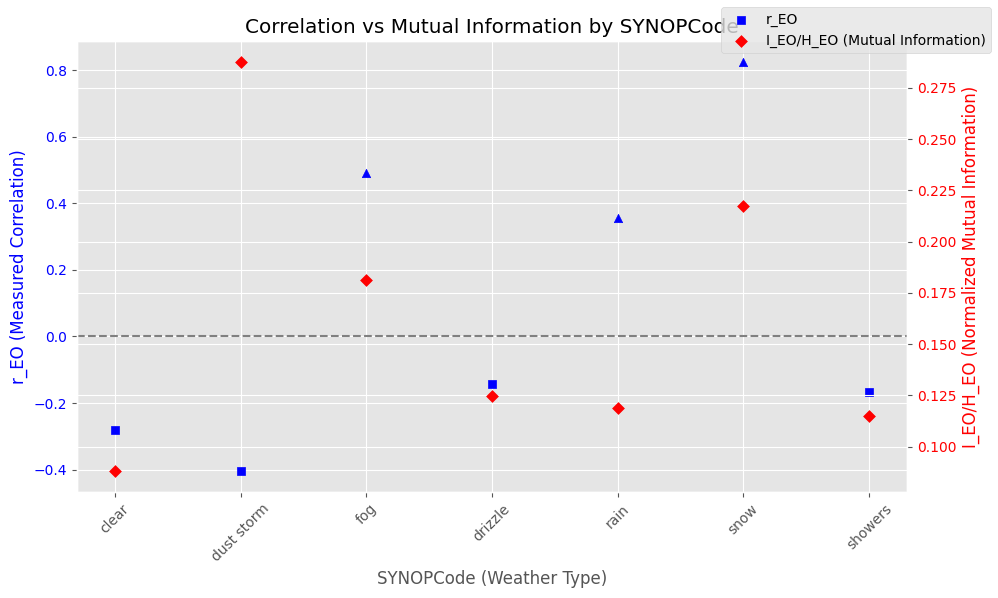

In [27]:
# Create a new column for categorical x positions
corr_df['CategoryIndex'] = range(len(corr_df))

# Plotting with corrected x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis for r_EO
for idx, row in corr_df.iterrows():
    marker = '^' if row['r_EO'] >= 0 else 's'
    ax1.scatter(row['CategoryIndex'], row['r_EO'], color='blue', marker=marker, label='r_EO' if idx == 0 else "")

ax1.set_xlabel('SYNOPCode (Weather Type)')
ax1.set_xticks(corr_df['CategoryIndex'])
ax1.set_xticklabels([synop_labels.get(code, str(code)) for code in corr_df['SYNOPCode']], rotation=45)
ax1.set_ylabel('r_EO (Measured Correlation)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(0, color='gray', linestyle='--')

# Right y-axis for I_EO/H_EO (Mutual Information)
ax2 = ax1.twinx()
ax2.scatter(corr_df['CategoryIndex'], corr_df['I_EO_H_EO'], color='red', marker='D', label='I_EO/H_EO (Mutual Information)')
ax2.set_ylabel('I_EO/H_EO (Normalized Mutual Information)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Correlation vs Mutual Information by SYNOPCode')
plt.tight_layout()
plt.show()
